In [28]:
# Rough demo of how we could sort activities and products in "composition hiearchy"

In [29]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
sns.set()
import warnings; warnings.simplefilter('ignore')
%matplotlib inline


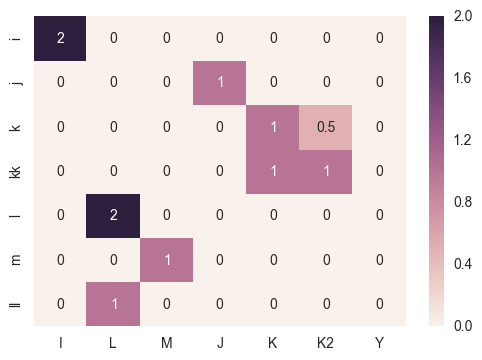

In [30]:
# Supply table
V = pd.read_excel('triangulationSUT.xls', sheetname='V').fillna(0)
sns.heatmap(V,annot=True)

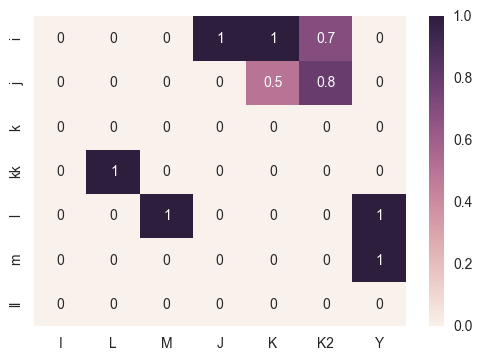

In [31]:
# Use table
U = pd.read_excel('triangulationSUT.xls', sheetname='U').fillna(0)
sns.heatmap(U,annot=True)

In [32]:
# List of products supplied so far in the sequence
supplied = []

# Lists of products used so far in the sequence
used = []

# the hierarchy, the whole point of this calculation
hiearchy=[]

In [33]:
# List dependencies of each activity
deps = pd.Series()
for c in U.columns:
    bo = list(U[c] != 0)
    deps[c] = set(U.index[bo])
deps

I         {}
L       {kk}
M        {l}
J        {i}
K     {j, i}
K2    {j, i}
Y     {m, l}
dtype: object

In [34]:
def next_hierarchy_level(hiearchy, supplied, deps, used):
    """ Goes up one step in the hiearchy ladder
    * Identify next activity
    * Identify the first use of a defined product
    * update 'supplied' and 'used' lists
    """
    
    def update_lists(hiearchy, supplied, deps, used):
        # new product use
        new_use = list(deps[ix] - set(used))
        new_supply = list(set(V.index[V[ix] != 0]) - set(supplied))
                
        # Update record
        supplied += new_supply
        used += new_use
        hiearchy += [(ix, new_use)]
        return hiearchy, supplied, used

        

    # All activities not yet in the hierarchy
    new_ixs = [i for i in deps.index if i not in [j[0] for j in hiearchy]]

    # At first, we are strict: new activity must have all its inputs covered
    max_not_covered=0
    
    # Loop until we've found our next activity
    found_one = False
    while not found_one:
        # Loop one activity at a time
        if max_not_covered == 0:
            for ix in new_ixs:
                # check if all requirements of technology can be met by products already in use
                not_covered = deps[ix] - set(used)
                if len(not_covered) <= max_not_covered:
                    hiearchy, supplied, used = update_lists(hiearchy, supplied, deps, used)
                    found_one = True
                    max_not_covered = 0
                    break
        if not found_one:
            for ix in new_ixs:
                # check if all requirements of technology can be met by products already suplied
                not_covered = deps[ix] - set(supplied)
                if len(not_covered) <= max_not_covered:
                    hiearchy, supplied, used = update_lists(hiearchy, supplied, deps, used)
                    found_one = True
                    max_not_covered = 0
                    break
        if not found_one:
            # Still not found new activity, relax restrictions that all inputs be covered
            max_not_covered += 1
            break
        
    return hiearchy, supplied, used

In [36]:
for i in V.columns:
    hiearchy, supplied, used = next_hierarchy_level(hiearchy, supplied, deps, used)
    print(hiearchy)
    print(supplied)


[('I', [])]
['i']
[('I', []), ('J', ['i'])]
['i', 'j']
[('I', []), ('J', ['i']), ('K', ['j'])]
['i', 'j', 'kk', 'k']
[('I', []), ('J', ['i']), ('K', ['j']), ('K2', [])]
['i', 'j', 'kk', 'k']
[('I', []), ('J', ['i']), ('K', ['j']), ('K2', []), ('L', ['kk'])]
['i', 'j', 'kk', 'k', 'll', 'l']
[('I', []), ('J', ['i']), ('K', ['j']), ('K2', []), ('L', ['kk']), ('M', ['l'])]
['i', 'j', 'kk', 'k', 'll', 'l', 'm']
[('I', []), ('J', ['i']), ('K', ['j']), ('K2', []), ('L', ['kk']), ('M', ['l']), ('Y', ['m'])]
['i', 'j', 'kk', 'k', 'll', 'l', 'm']
